In [58]:
import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import bayespy 

import pymc3 as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# pd.set_option('display.max_columns', None)

from utils import *

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

#%load_ext watermark
#%watermark -dtmvgp numpy,scipy,matplotlib,pandas,seaborn,pymc3,theano,arviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# data_netw = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_network.csv').drop(columns= ['TOTAL_CONV'])
# data_dig = pd.read_csv(r'x:\CAO\Team\Data Science\performance_link\Bayesian_MLR_Starkis\data\tv_digital.csv')

data_netw = pd.read_csv('../data/tv_day.csv').drop(columns= ['TOTAL_CONV'])
data_dig = pd.read_csv('../data/tv_digital.csv')

# combining 2 dfs
data = pd.concat([data_netw, data_dig], axis= 1)

# Filter the rows where sum of the values = 0
# data = data[data.iloc[:,:-1].sum(axis=1)!=0]

In [60]:
data.head()

,TV_MONDAY,TV_TUESDAY,TV_WEDNESDAY,TV_THURSDAY,TV_FRIDAY,TV_SATURDAY,TV_SUNDAY,DIGITAL_HX,DIGITAL_TREMOR,TOTAL_CONV
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39,0.0,16
1,10.0,15.0,16.0,20.0,31.0,23.0,9.0,1.00,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.00,0.0,0
3,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.00,0.0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.00,0.0,0


In [61]:
# data = data[data.TOTAL_CONV != 0]
data = data[(data.TOTAL_CONV<20)] # & (data.TOTAL_CONV!=0)

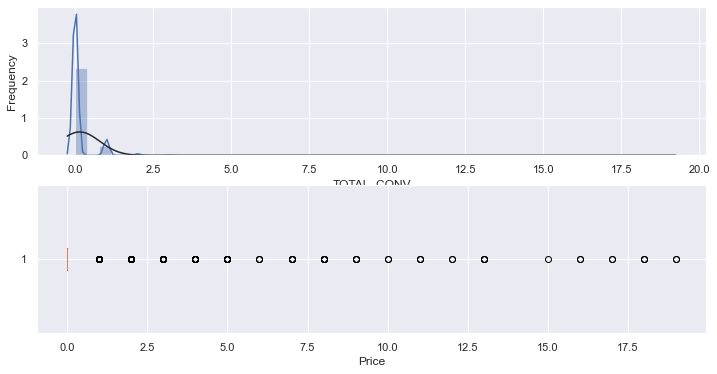

In [62]:
target_distribution(data.TOTAL_CONV)

In [63]:
x = data[[col for col in data.columns if col != 'TOTAL_CONV']].values
y = data.TOTAL_CONV.values

In [45]:
# # Scaling all data with MinMaxScaler
# scaller = MinMaxScaler()
# data= pd.DataFrame(scaller.fit_transform(data), columns= data.columns)

### ZeroInflatedNegativeBinomial as Likelihood

In [53]:
with pm.Model() as model_zero:

    # Intercept
    alpha = pm.Normal('alpha', mu=y.mean(), sd=20)

    # Slope
    beta = pm.HalfFlat('beta', shape = len(data.columns[:-1]))

    # Error term
    eps = pm.HalfCauchy('eps', 5)

    # Expected value of outcome (ML Regression with vectors)
    mu = alpha + pm.math.dot(x, beta)

    # Likelihood
    conv = pm.ZeroInflatedPoisson('conversion', 
                                  theta= mu, 
                                  psi= 0.7,  
                                  observed=y)
    # posterior
    trace_zero = pm.sample(chains = 4, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 677 seconds.


In [54]:
az.summary(trace_zero)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.167,0.004,0.161,0.174,0.000,0.000,4799.0,2955.0,1.0
beta[0],0.000,0.000,0.000,0.000,0.000,0.000,4048.0,1832.0,1.0
beta[1],0.000,0.000,0.000,0.000,0.000,0.000,4271.0,2296.0,1.0
beta[2],0.000,0.000,0.000,0.000,0.000,0.000,3498.0,2245.0,1.0
beta[3],0.000,0.000,0.000,0.000,0.000,0.000,3889.0,1823.0,1.0
beta[4],0.000,0.000,0.000,0.000,0.000,0.000,3414.0,1863.0,1.0
beta[5],0.000,0.000,0.000,0.000,0.000,0.000,3600.0,2058.0,1.0
beta[6],0.000,0.000,0.000,0.000,0.000,0.000,3773.0,1780.0,1.0
beta[7],0.437,0.029,0.382,0.492,0.000,0.000,5063.0,3051.0,1.0
beta[8],0.160,0.021,0.121,0.199,0.000,0.000,5328.0,2804.0,1.0


posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


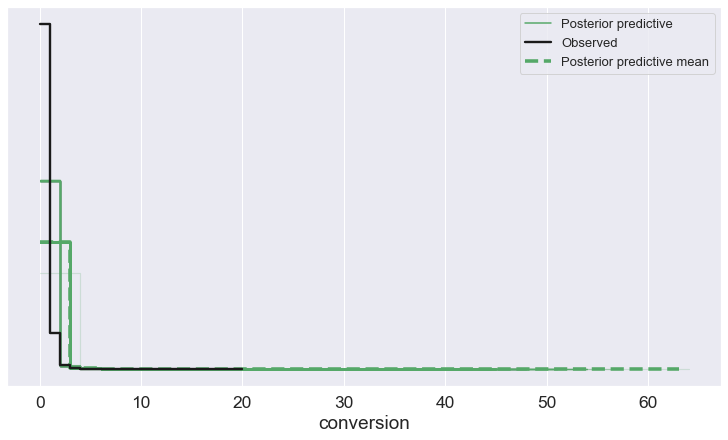

R2 for Model is : 0.827


In [64]:
ppc_check(model=model_zero, data = data, trace= trace_zero)

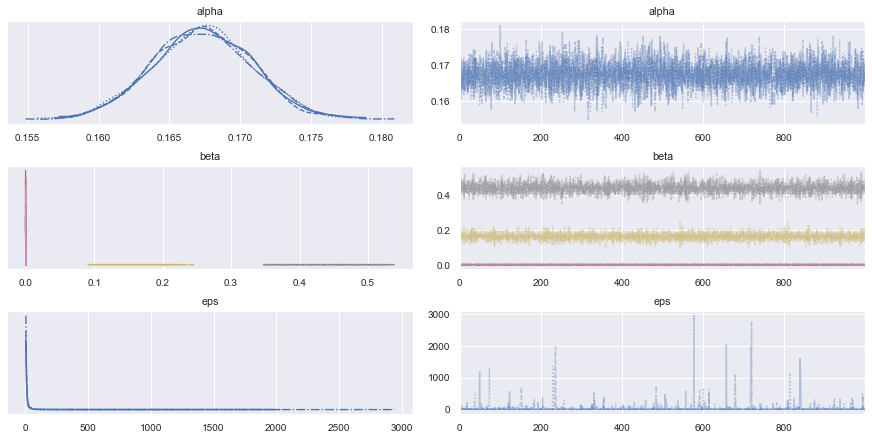

In [65]:
az.plot_trace(trace_zero)
plt.show()

In [66]:
az.summary(trace_zero,
           var_names = 'beta'
          ).set_index(data[[col for col in data.columns if col != 'TOTAL_CONV']].columns)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TV_MONDAY,0.000,0.000,0.000,0.000,0.0,0.0,4048.0,1832.0,1.0
TV_TUESDAY,0.000,0.000,0.000,0.000,0.0,0.0,4271.0,2296.0,1.0
TV_WEDNESDAY,0.000,0.000,0.000,0.000,0.0,0.0,3498.0,2245.0,1.0
TV_THURSDAY,0.000,0.000,0.000,0.000,0.0,0.0,3889.0,1823.0,1.0
TV_FRIDAY,0.000,0.000,0.000,0.000,0.0,0.0,3414.0,1863.0,1.0
TV_SATURDAY,0.000,0.000,0.000,0.000,0.0,0.0,3600.0,2058.0,1.0
TV_SUNDAY,0.000,0.000,0.000,0.000,0.0,0.0,3773.0,1780.0,1.0
DIGITAL_HX,0.437,0.029,0.382,0.492,0.0,0.0,5063.0,3051.0,1.0
DIGITAL_TREMOR,0.160,0.021,0.121,0.199,0.0,0.0,5328.0,2804.0,1.0


In [68]:
samples_zero = ppc_check(model_zero, trace_zero, data, predictions = True, plot_ppc=False)

posterior predictive variable conversion's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


R2 for Model is : 0.828


In [78]:
filtered = samples_zero['conversion'][:, np.all(samples_zero['conversion']<=y.max(), axis = 0)]

In [ ]:
predictions = ppc_check(model = mo, 
                        trace = trace_weibull, 
                        data = data, 
                        predictions = True, 
                        plot_ppc = True, 
                        glm = False)

In [82]:
filtered

array([[1, 1, 0, ..., 0, 1, 0],
       [0, 0, 9, ..., 0, 0, 0],
       [0, 0, 8, ..., 0, 0, 0],
       ...,
       [2, 0, 0, ..., 0, 1, 0],
       [2, 0, 7, ..., 0, 0, 0],
       [0, 0, 9, ..., 0, 0, 0]])

KeyboardInterrupt: 

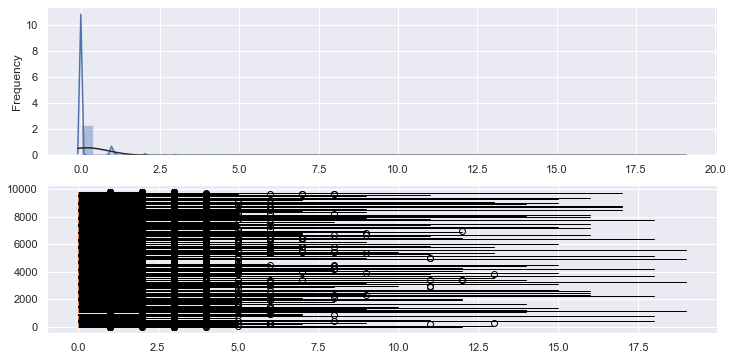

In [87]:
target_distribution(filtered)